In [100]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  
import matplotlib.patches as mpatches

# Модуль 1

## Задание 2

In [4]:
data = {'Категория':[
                    'Развитие условий для досуга молодежи',
                    'Перспективы трудоустройства, карьеры',
                    'Экологические проблемы',
                    'Защита и помощь животным',
                    'Развитие образования',
                    'Борьба с наркоманией, алкоголизмом',
                    'Борьба с преступностью, безопасность',
                    'Развитие городской среды',
                    'Решение жилищных проблем',
                    'Помощь нуждающимся',
                    'Благоустройство двора',
                    'Создание условий для занятия спортом',
                    'Защита прав разных категорий населения',
                    'Решение проблем города',
                    'Патриотизм, гражданственность'
                    ],
        'Процент':[
                    37.40, 36.00, 35.80, 33.40, 32.70, 28.80, 28.50, 27.20, 23.50, 23.30, 22.90, 22.80, 22.70, 18.50, 11.60
                    ]
       }
df = pd.DataFrame(data)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Категория  15 non-null     object 
 1   Процент    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 372.0+ bytes


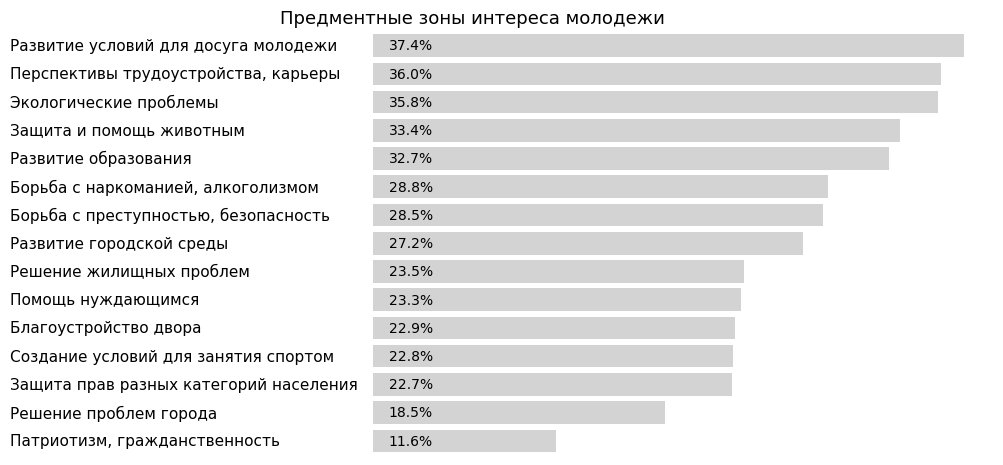

In [9]:
plt.figure(figsize=(8,5.5))
ax = sns.barplot(data=df,y='Категория',orient='h',x='Процент',color='lightgrey')
#ax.bar_label(ax.containers[0], fmt='%0.1f%%')

# Подготовка данных
#df_sorted = df.sort_values('Процент')  # сортировка для наглядности
categories = df['Категория']
values = df['Процент']

# Убираем рамки графика
for spine in ax.spines.values():
    spine.set_visible(False)

# Подписи значений — слева от начала каждого бара
for i, value in enumerate(values):
    ax.text(x=1, y=i, s=f'{value:.1f}%', va='center', ha='left', fontsize=10)  
    
# Выравниваем текст по левому краю. 
#Текст лучше выравнять по левому краю, так не будет рваного края слева и глаз будет знать, где начинается новая строка, про это тоже еще будем говорить в главе про текст
ax.set_yticks([])
for i, label in enumerate(categories):
    ax.text(x=-23, y=i, s=label, va='center', ha='left', fontsize=11)

plt.ylabel('')
plt.xlabel('')

ax.xaxis.set_visible(False)
plt.title('Предментные зоны интереса молодежи',loc='left',fontsize=13, x=-0.15)


plt.show()

## Задание 2

In [12]:
df_2 = pd.read_csv('/Users/kemran/Downloads/2_Страховые случаи.csv')

df_2['Month, Day, Year of Filed week ended'] = pd.to_datetime(df_2['Month, Day, Year of Filed week ended'])
#df_2['Formatted Date'] = df_2['Month, Day, Year of Filed week ended'].dt.strftime('%d/%m/%y')
df_2 = df_2.sort_values(by='Month, Day, Year of Filed week ended')

In [14]:
df_2

,"Month, Day, Year of Filed week ended",Initial Claims,Initial Claims 4-Week Avg
100,2022-11-19,837,718.50
25,2022-11-26,772,757.25
104,2022-12-03,1091,836.50
15,2022-12-10,968,917.00
14,2022-12-17,844,918.75
...,...,...,...
101,2024-11-09,890,655.00
39,2024-11-16,868,747.00
77,2024-11-23,916,842.50
3,2024-11-30,708,845.50


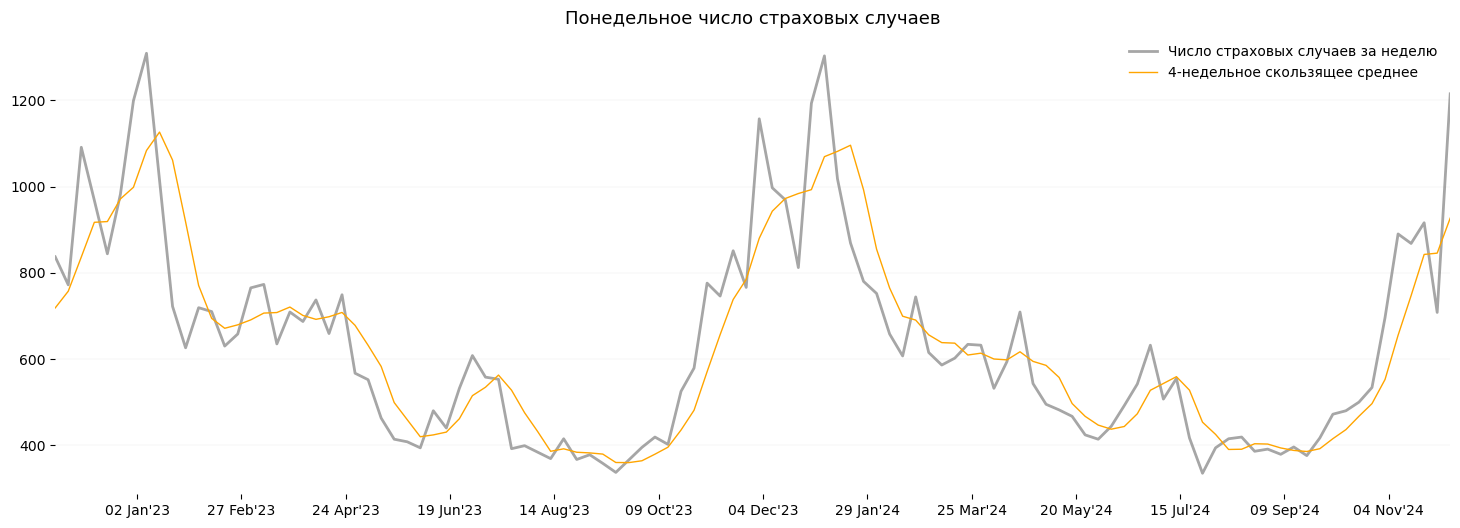

In [269]:
import matplotlib.dates as mdates
plt.figure(figsize=(18,6), dpi=100)
ax = plt.gca()

# Линия 1 — простая (Initial Claims)
ax.plot(df_2['Month, Day, Year of Filed week ended'], df_2['Initial Claims'], linewidth=2, alpha=0.7, color='grey', label='Число страховых случаев за неделю')

# Линия 2 — скользящее среднее (Initial Claims 4-Week Avg)
sns.lineplot(data=df_2, x='Month, Day, Year of Filed week ended', y='Initial Claims 4-Week Avg', ax=ax, linewidth=1, alpha=1, label='4-недельное скользящее среднее', color='orange')


# Формат подписи: 23 Nov'23
custom_formatter = mdates.DateFormatter("%d %b'%y")
ax.xaxis.set_major_formatter(custom_formatter)

# Установим тики каждые 4 недели (28 дней)
locator = mdates.WeekdayLocator(interval=8, byweekday=mdates.MO)  # каждый 4-й понедельник
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=0)


# === Задаём интервал оси X от min до max даты ===
min_date = df_2['Month, Day, Year of Filed week ended'].min()
max_date = df_2['Month, Day, Year of Filed week ended'].max()
ax.set_xlim([min_date, max_date])

# Убираем рамки графика
for spine in ax.spines.values():
    spine.set_visible(False)

# Сделаем гридлайн еле заметный
ax.grid(True, which='major', axis='y', color='#dddddd', linewidth=0.2)

plt.title('Понедельное число страховых случаев',fontsize=13)
plt.xlabel('')
plt.ylabel('')
plt.legend(frameon=False)

plt.show()


# Модуль 2

## Задание 1

In [62]:

# Исходные данные
data = {
    'Country': ['India', 'United States', 'China', 'Brazil', 'Russia', 
                'Indonesia', 'Pakistan', 'Bangladesh', 'Mexico', 'Nigeria'],
    'Pigeons_millions': [350, 225, 175, 125, 90, 65, 65, 60, 60, 50],
    'Population_millions': [1420, 332, 1410, 213, 146, 275, 240, 170, 130, 220],
    'Region': ['Asia','North America','Asia','South America','Europe','Asia','Asia','Asia','North America','Africa']
}

# Создаем DataFrame
df_pigeons = pd.DataFrame(data)

# Вычисляем голубей на миллион населения
df_pigeons['Pigeons_per_people'] = round(df_pigeons['Pigeons_millions'] / df_pigeons['Population_millions'],2)

df_pigeons

,Country,Pigeons_millions,Population_millions,Region,Pigeons_per_people
0,India,350,1420,Asia,0.25
1,United States,225,332,North America,0.68
2,China,175,1410,Asia,0.12
3,Brazil,125,213,South America,0.59
4,Russia,90,146,Europe,0.62
5,Indonesia,65,275,Asia,0.24
6,Pakistan,65,240,Asia,0.27
7,Bangladesh,60,170,Asia,0.35
8,Mexico,60,130,North America,0.46
9,Nigeria,50,220,Africa,0.23


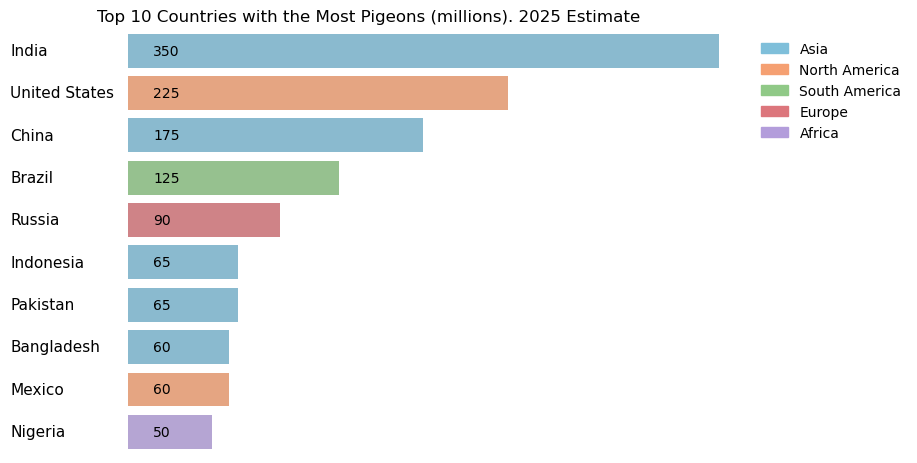

In [171]:
df_pigeons_sorted = df_pigeons.sort_values(by='Pigeons_millions',ascending=False)

plt.figure(figsize=(8,5.5))

# Подготовка данных
categories = df_pigeons_sorted['Country']
values = df_pigeons_sorted['Pigeons_millions']

region_palette = {
    'Asia': '#7fbfda',           # небесно-голубой
    'North America': '#f5a072',  # тёплый оранжево-персиковый
    'South America': '#90c987',  # мягкий зелёный
    'Europe': '#dc767c',         # пудрово-розовый с насыщенностью
    'Africa': '#b39ddb'          # сиреневый (в сторону фиолетового)
}

colors = df_pigeons_sorted['Region'].map(region_palette).tolist()

bar_colors = df_pigeons_sorted['Region'].map(region_palette).tolist()

# Строим график
ax = sns.barplot(data=df_pigeons_sorted,y='Country',orient='h',x='Pigeons_millions',palette=colors)


# Убираем рамки графика
for spine in ax.spines.values():
    spine.set_visible(False)

# Подписи значений — слева от начала каждого бара
for i, value in enumerate(values):
    ax.text(x=15, y=i, s=value, va='center', fontsize=10)  
    
#Выравниваем текст по левому краю. 
#Текст лучше выравнять по левому краю, так не будет рваного края слева и глаз будет знать, где начинается новая строка, про это тоже еще будем говорить в главе про текст
ax.set_yticks([])
for i, label in enumerate(categories):
    ax.text(x=-70, y=i, s=label, va='center', ha='left', fontsize=11)

plt.ylabel('')
plt.xlabel('')

legend_handles = [mpatches.Patch(color=color, label=region) 
                  for region, color in region_palette.items()]
plt.legend(handles=legend_handles, title=None, bbox_to_anchor=(1, 1), loc='upper left',frameon=False)


ax.xaxis.set_visible(False)
plt.title('Top 10 Countries with the Most Pigeons (millions). 2025 Estimate',loc='left',fontsize=12, x=-0.05)


plt.show()

## Задание 2

In [227]:
import pandas as pd
from io import StringIO

data = """
Month of Createdat,Source,Orders
01/04/2016,Twitter,61
01/05/2016,Twitter,210
01/06/2016,Twitter,200
01/07/2016,Twitter,171
01/08/2016,Twitter,102
01/09/2016,Twitter,128
01/10/2016,Twitter,380
01/11/2016,Twitter,291
01/12/2016,Twitter,314
01/01/2017,Twitter,171
01/02/2017,Twitter,190
01/03/2017,Twitter,352
01/04/2017,Twitter,186
01/05/2017,Twitter,65
01/06/2017,Twitter,98
01/07/2017,Twitter,108
01/08/2017,Twitter,154
01/09/2017,Twitter,179
01/10/2017,Twitter,46
01/11/2017,Twitter,83
01/12/2017,Twitter,63
01/01/2018,Twitter,53
01/02/2018,Twitter,42
01/03/2018,Twitter,17
01/04/2018,Twitter,14
01/05/2018,Twitter,28
01/06/2018,Twitter,18
01/07/2018,Twitter,2
01/08/2018,Twitter,23
01/09/2018,Twitter,8
01/10/2018,Twitter,4
01/11/2018,Twitter,6
01/12/2018,Twitter,0
01/01/2019,Twitter,1
01/02/2019,Twitter,3
01/03/2019,Twitter,0
01/04/2019,Twitter,1
01/04/2016,Organic,32
01/05/2016,Organic,89
01/06/2016,Organic,257
01/07/2016,Organic,149
01/08/2016,Organic,205
01/09/2016,Organic,227
01/10/2016,Organic,216
01/11/2016,Organic,176
01/12/2016,Organic,315
01/01/2017,Organic,192
01/02/2017,Organic,192
01/03/2017,Organic,222
01/04/2017,Organic,192
01/05/2017,Organic,174
01/06/2017,Organic,197
01/07/2017,Organic,183
01/08/2017,Organic,137
01/09/2017,Organic,143
01/10/2017,Organic,87
01/11/2017,Organic,73
01/12/2017,Organic,95
01/01/2018,Organic,44
01/02/2018,Organic,45
01/03/2018,Organic,12
01/04/2018,Organic,30
01/05/2018,Organic,7
01/06/2018,Organic,20
01/07/2018,Organic,13
01/08/2018,Organic,18
01/09/2018,Organic,1
01/10/2018,Organic,0
01/11/2018,Organic,0
01/12/2018,Organic,17
01/01/2019,Organic,0
01/02/2019,Organic,0
01/03/2019,Organic,4
01/04/2019,Organic,0
01/04/2016,Google,52
01/05/2016,Google,67
01/06/2016,Google,178
01/07/2016,Google,198
01/08/2016,Google,188
01/09/2016,Google,236
01/10/2016,Google,274
01/11/2016,Google,349
01/12/2016,Google,290
01/01/2017,Google,245
01/02/2017,Google,196
01/03/2017,Google,248
01/04/2017,Google,252
01/05/2017,Google,191
01/06/2017,Google,92
01/07/2017,Google,85
01/08/2017,Google,160
01/09/2017,Google,121
01/10/2017,Google,82
01/11/2017,Google,63
01/12/2017,Google,24
01/01/2018,Google,67
01/02/2018,Google,8
01/03/2018,Google,17
01/04/2018,Google,12
01/05/2018,Google,30
01/06/2018,Google,4
01/07/2018,Google,24
01/08/2018,Google,16
01/09/2018,Google,3
01/10/2018,Google,1
01/11/2018,Google,0
01/12/2018,Google,7
01/01/2019,Google,0
01/02/2019,Google,12
01/03/2019,Google,3
01/04/2019,Google,3
01/04/2016,Facebook,11
01/05/2016,Facebook,67
01/06/2016,Facebook,98
01/07/2016,Facebook,271
01/08/2016,Facebook,265
01/09/2016,Facebook,312
01/10/2016,Facebook,242
01/11/2016,Facebook,266
01/12/2016,Facebook,252
01/01/2017,Facebook,275
01/02/2017,Facebook,206
01/03/2017,Facebook,219
01/04/2017,Facebook,255
01/05/2017,Facebook,174
01/06/2017,Facebook,173
01/07/2017,Facebook,155
01/08/2017,Facebook,115
01/09/2017,Facebook,108
01/10/2017,Facebook,35
01/11/2017,Facebook,77
01/12/2017,Facebook,82
01/01/2018,Facebook,50
01/02/2018,Facebook,31
01/03/2018,Facebook,29
01/04/2018,Facebook,50
01/05/2018,Facebook,15
01/06/2018,Facebook,6
01/07/2018,Facebook,23
01/08/2018,Facebook,6
01/09/2018,Facebook,6
01/10/2018,Facebook,22
01/11/2018,Facebook,0
01/12/2018,Facebook,4
01/01/2019,Facebook,6
01/02/2019,Facebook,0
01/03/2019,Facebook,0
01/04/2019,Facebook,0
01/04/2016,Affiliate,20
01/05/2016,Affiliate,219
01/06/2016,Affiliate,166
01/07/2016,Affiliate,240
01/08/2016,Affiliate,199
01/09/2016,Affiliate,129
01/10/2016,Affiliate,235
01/11/2016,Affiliate,158
01/12/2016,Affiliate,346
01/01/2017,Affiliate,192
01/02/2017,Affiliate,262
01/03/2017,Affiliate,172
01/04/2017,Affiliate,84
01/05/2017,Affiliate,203
01/06/2017,Affiliate,168
01/07/2017,Affiliate,152
01/08/2017,Affiliate,97
01/09/2017,Affiliate,70
01/10/2017,Affiliate,84
01/11/2017,Affiliate,103
01/12/2017,Affiliate,39
01/01/2018,Affiliate,16
01/02/2018,Affiliate,32
01/03/2018,Affiliate,31
01/04/2018,Affiliate,4
01/05/2018,Affiliate,21
01/06/2018,Affiliate,17
01/07/2018,Affiliate,19
01/08/2018,Affiliate,18
01/09/2018,Affiliate,0
01/10/2018,Affiliate,6
01/11/2018,Affiliate,6
01/12/2018,Affiliate,3
01/01/2019,Affiliate,0
01/02/2019,Affiliate,8
01/03/2019,Affiliate,1
01/04/2019,Affiliate,0
"""

# Чтение строки в датафрейм
df_trafic = pd.read_csv(StringIO(data))

# Преобразование даты
df_trafic['Month of Createdat'] = pd.to_datetime(df_trafic['Month of Createdat'], format='%d/%m/%Y')

# Сортировка (по желанию)
df_trafic = df_trafic.sort_values(by=['Source', 'Month of Createdat'])
df_trafic['Year'] = df_trafic['Month of Createdat'].dt.year

In [310]:
df_trafic['Source'].unique()

array(['Affiliate', 'Facebook', 'Google', 'Organic', 'Twitter'],
      dtype=object)

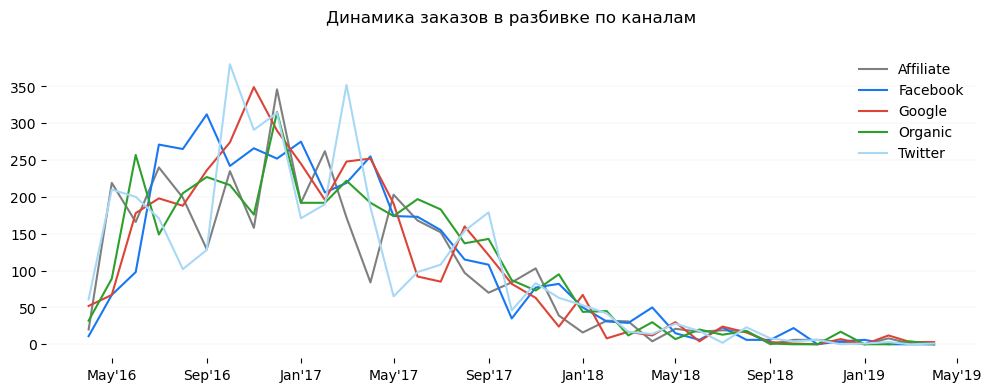

In [330]:
df_trafic_agg = df_trafic.groupby(['Year','Source'])['Orders'].sum().reset_index()

plt.figure(figsize=(12,4))

source_palette = {
    'Affiliate': '#7f7f7f',
    'Facebook': '#1877F2',
    'Google': '#DB4437',
    'Organic': '#2ca02c',
    'Twitter': '#A7D8F5'
}

# ax = sns.lineplot(data=df_trafic_agg,x='Year',y='Orders',hue='Source',palette=source_palette)
ax = sns.lineplot(data=df_trafic,x='Month of Createdat',y='Orders',hue='Source',palette=source_palette)

# Формат подписи: Nov'23
custom_formatter = mdates.DateFormatter("%b'%y")
ax.xaxis.set_major_formatter(custom_formatter)


plt.xlabel('')
plt.ylabel('')
for spine in ax.spines.values():
    spine.set_visible(False)


# Показываем только 4 года на оси X
#ax.set_xticks([2016, 2017, 2018, 2019])    

# Сделаем гридлайн еле заметный
ax.grid(True, which='major', axis='y', color='#dddddd', linewidth=0.2)

plt.legend(title=None,frameon=False,loc='upper right')
plt.title('Динамика заказов в разбивке по каналам',pad=20)

plt.show()


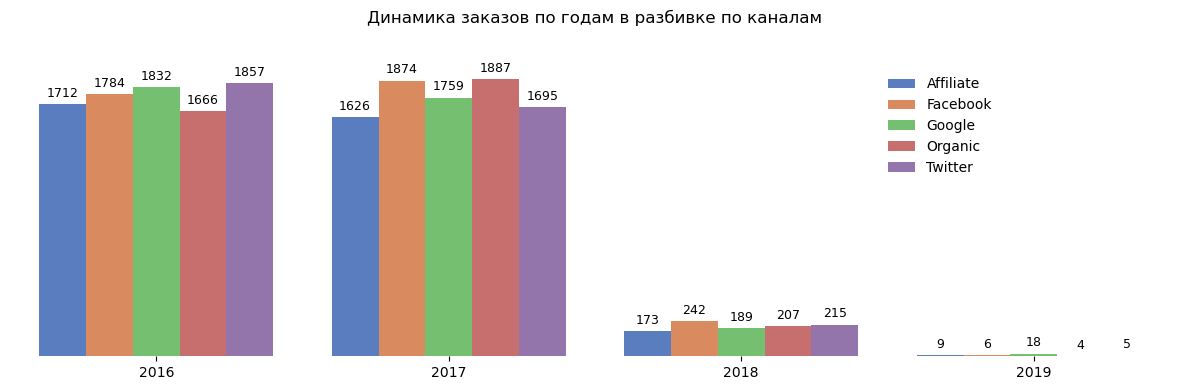

In [326]:
import matplotlib.pyplot as plt

# Убедимся, что Year — строка, чтобы ось X была категориальной
df_trafic_agg['Year'] = df_trafic_agg['Year'].astype(str)

plt.figure(figsize=(12, 4))
sns.set_palette('muted')

# Отрисовка столбчатой диаграммы
ax = sns.barplot(data=df_trafic_agg, x='Year', y='Orders', hue='Source')

# Убираем подписи осей
plt.xlabel('')
plt.ylabel('')

# Убираем рамки
for spine in ax.spines.values():
    spine.set_visible(False)

# Добавляем подписи значений поверх столбцов
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=3)

# Удаляем ось Y
ax.yaxis.set_visible(False)               # скрывает шкалу оси
ax.spines['left'].set_visible(False)      # скрывает левую рамку

# Легенда
plt.legend(bbox_to_anchor=(0.85, 1), title=None, frameon=False, loc='upper right')

# Заголовок
plt.title('Динамика заказов по годам в разбивке по каналам', pad=30)

plt.tight_layout()
plt.show()
